In [0]:
from random import shuffle, randint
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from math import atan2

In [0]:
# # data generation
# # particle_id x y
# list = []
# for particle_id in range(0, 4):
#     nopoints = randint(50, 200)
#     print(f'Cluster {particle_id} has {nopoints} points')
#     for point in range(0, nopoints):
#         x = randint(particle_id * 80, particle_id * 80 + 100)
#         y = randint(particle_id * 80, particle_id * 80 + 100)
#         list.append((particle_id, x, y))

# shuffle(list)

# file_content = "\n".join([f'{tuple[0]} {tuple[1]} {tuple[2]}'for tuple in list])

# dbutils.fs.put('/dbfs/demo/convex-hull-4.txt', file_content, overwrite=True)

In [0]:
def parseLine(line):
    number_texts = line.split(' ')
    try:
        tuple = (int(number_texts[0].strip()),(int(number_texts[1].strip()), int(number_texts[2].strip())))
    except:
        print("Error parsing line: " + line)
    return tuple

In [0]:
lines = spark.read.text('/dbfs/demo/convex-hull-4.txt')
points = lines.rdd.map(lambda x : parseLine(x.value))

In [0]:
def polar_angle_and_distance(p0, p1):
    y_span = p1[1] - p0[1]
    x_span = p1[0] - p0[0]
    return atan2(y_span, x_span), x_span**2 + y_span**2

def ccw(a, b, c):
    return (b[0] - a[0]) * (c[1] - a[1]) - (c[0] - a[0]) * (b[1] - a[1])

def find_convex_hull(points):
    # find anchor with lowest y (and if there are more than 1, lower x)
    anchor_point = points[0]
    for point in points:
        if (point[1] < anchor_point[1]) or (point[1] == anchor_point[1] and point[0] < anchor_point[0]):
            anchor_point = point

    def sort_by_polar_angle_and_distance(p):
        angle, distance = polar_angle_and_distance(anchor_point, p)
        return (angle, distance)
    
    # sort by polar angle with anchor_point, then by distance
    sorted_points = sorted(points, key=sort_by_polar_angle_and_distance)

    convex_hull = [anchor_point, sorted_points[1]]

    for point in sorted_points[2:]:
        while len(convex_hull) > 1 and ccw(convex_hull[-2], convex_hull[-1], point) <= 0:
            convex_hull.pop()
        convex_hull.append(point)
    
    return convex_hull

In [0]:
def process_group(points_rs):
    points = list(points_rs)
    return find_convex_hull(points)

In [0]:
convex_hulls = points.groupByKey().mapValues(process_group).collect()

In [0]:
initial_points = points.collect()

In [0]:
initial_points

Out[23]: [(1, (96, 86)),
 (1, (164, 168)),
 (3, (323, 243)),
 (3, (303, 337)),
 (1, (84, 106)),
 (1, (103, 135)),
 (2, (165, 164)),
 (2, (233, 195)),
 (1, (108, 126)),
 (1, (100, 171)),
 (2, (247, 195)),
 (2, (198, 204)),
 (3, (260, 339)),
 (3, (302, 281)),
 (3, (268, 262)),
 (1, (166, 92)),
 (2, (217, 173)),
 (0, (39, 71)),
 (3, (327, 314)),
 (2, (180, 186)),
 (3, (323, 286)),
 (2, (227, 193)),
 (3, (284, 263)),
 (1, (160, 148)),
 (1, (165, 99)),
 (2, (259, 234)),
 (1, (159, 133)),
 (0, (2, 25)),
 (3, (289, 286)),
 (2, (232, 251)),
 (3, (285, 274)),
 (1, (177, 97)),
 (1, (168, 177)),
 (2, (237, 260)),
 (2, (235, 256)),
 (3, (244, 243)),
 (1, (180, 90)),
 (2, (175, 188)),
 (1, (143, 145)),
 (1, (178, 136)),
 (3, (271, 277)),
 (2, (205, 227)),
 (3, (281, 296)),
 (3, (333, 279)),
 (0, (78, 24)),
 (3, (330, 319)),
 (2, (168, 214)),
 (2, (202, 212)),
 (3, (284, 262)),
 (0, (49, 43)),
 (3, (287, 251)),
 (2, (246, 215)),
 (2, (258, 249)),
 (0, (23, 95)),
 (3, (306, 279)),
 (0, (42, 81)),
 (0

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Visualization
def plot_points_and_hulls(initial_points, hulls):
    plt.figure(figsize=(10, 8))

    # Convert initial points to a dictionary for easy lookup
    points_dict = {}
    for cluster_id, point in initial_points:
        if cluster_id not in points_dict:
            points_dict[cluster_id] = []
        points_dict[cluster_id].append(point)

    # Plot initial points
    for cluster_id, points in points_dict.items():
        points = np.array(points)
        plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {cluster_id}')

    # Plot convex hulls
    for cluster_id, hull_points in hulls:
        if len(hull_points) >= 3:  # Convex hull requires at least 3 points
            hull_points = np.array(hull_points)
            hull_points = np.append(hull_points, [hull_points[0]], axis=0)  # Close the hull loop
            plt.plot(hull_points[:, 0], hull_points[:, 1], linestyle='-', linewidth=2, label=f'Hull {cluster_id}')
        else:
            print(f"Not enough points for convex hull in cluster {cluster_id}")

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Points and Convex Hulls')
    plt.legend()
    plt.grid(True)
    plt.show()


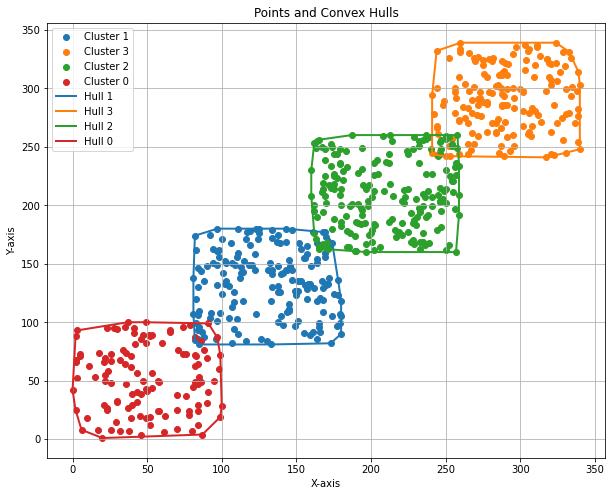

In [0]:
plot_points_and_hulls(initial_points, convex_hulls)